In [5]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"

import warnings

import numpy as np
import matplotlib.pyplot as plt
np.finfo(np.float64)


finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

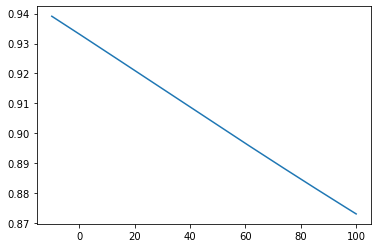

In [32]:
dG = 5.98209 * 1e3
R = 8.314

T = np.linspace(-10, 100, 300) + 273

K = np.exp(-dG/(R * T))

plt.plot(T - 273, 1 - K/(1+K))
plt.show()

In [50]:
A, B = np.random.random((10000, 1000)), np.random.random((1000, 10000))
%timeit A.dot(B)

3.02 s ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:

import theano.tensor as T
from theano import function, shared
from scipy.optimize import approx_fprime

In [16]:
def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-7, reltol=1e-3,
                epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.
        
    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

In [30]:
def f(xk):
    print("function evaluated")
    return np.asarray([xk[i] ** 2 for i in range(len(xk))]).sum()

def grad_f(xk):
    return np.array([2*xk[0], 2*xk[1]])

f([1, 2, 3])
# grad_f([1, 2, 3])

function evaluated


14

In [36]:
approx_fprime([1, 2, 100], f, 0.0001)

# gradients(np.array([10, 5]), f)

function evaluated
function evaluated
function evaluated
function evaluated


array([  2.00009999,   4.0001    , 200.00010001])

In [6]:
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y


f = function([x, y], z)

In [7]:
a = T.fvector() # declare variable
out = a[0:2]              # build symbolic expression
f = theano.function([a], out)   # compile function
f(np.asarray([0, 1, 2.2, 45, 77, 22], dtype=np.float32))

NameError: name 'theano' is not defined

In [62]:
state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

In [54]:
accumulator(15)

array(39)

In [56]:
state.get_value()

array(54)